# IRA Tweets: Analysis on Italian Tweets



In [19]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from datetime import datetime
from zipfile import ZipFile

import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx 

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# 1. Data Reading and Exploration

### Reading the data

> In reading phase we read the input data (both zip files), we extract italian tweets and we preprocess it. Finally we store the result in two new csv files to an easy future access. We consider also another csv file with without italian tweets with region column equal to USA, since we have noticed that are difficult to interpret. 

First we iterate through "russian-troll-tweets.zip" to read through every .csv file:

In [2]:
# Read the first IRA dataset
data_folder = './data/'
zip_file = ZipFile(data_folder+'russian-troll-tweets.zip')
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}

In [3]:
fs['IRAhandle_tweets_1.csv'].head(5)

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category
0,9.060000e+17,10_GOP,"""We have a sitting Democrat US Senator on tria...",Unknown,English,10/1/2017 19:58,10/1/2017 19:59,1052,9636,253,NaN,Right,0,0,RightTroll
1,9.060000e+17,10_GOP,Marshawn Lynch arrives to game in anti-Trump s...,Unknown,English,10/1/2017 22:43,10/1/2017 22:43,1054,9637,254,NaN,Right,0,0,RightTroll
2,9.060000e+17,10_GOP,Daughter of fallen Navy Sailor delivers powerf...,Unknown,English,10/1/2017 22:50,10/1/2017 22:51,1054,9637,255,RETWEET,Right,0,1,RightTroll
3,9.060000e+17,10_GOP,JUST IN: President Trump dedicates Presidents ...,Unknown,English,10/1/2017 23:52,10/1/2017 23:52,1062,9642,256,NaN,Right,0,0,RightTroll
4,9.060000e+17,10_GOP,"19,000 RESPECTING our National Anthem! #StandF...",Unknown,English,10/1/2017 2:13,10/1/2017 2:13,1050,9645,246,RETWEET,Right,0,1,RightTroll


We append all datasets together in one DataFrame:

In [4]:
data=pd.DataFrame()
for key,val in fs.items():
    data=pd.concat([data,val])

In [5]:
data.describe()

,external_author_id,following,followers,updates,new_june_2018,retweet
count,2.973367e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06,2.973371e+06
mean,1.296128e+17,3.433524e+03,7.018913e+03,1.049756e+04,2.078735e-01,4.408955e-01
std,3.036341e+17,5.609881e+03,1.458463e+04,1.768729e+04,4.057859e-01,4.964945e-01
min,3.497640e+07,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,1.930748e+09,3.270000e+02,3.200000e+02,1.787000e+03,0.000000e+00,0.000000e+00
50%,2.581835e+09,1.499000e+03,1.274000e+03,4.333000e+03,0.000000e+00,0.000000e+00
75%,3.254274e+09,4.730000e+03,1.060000e+04,1.234100e+04,0.000000e+00,1.000000e+00
max,9.812510e+17,7.621000e+04,2.512760e+05,1.661130e+05,1.000000e+00,1.000000e+00


Here we preprocess the data, we notice that *content*, the main attribute of our analysis, has some null values. We prefer removing them. Finally we remove duplicate values of *content*. 

In [6]:
data.isnull().any()

external_author_id     True
author                False
content                True
region                 True
language              False
publish_date          False
harvested_date        False
following             False
followers             False
updates               False
post_type              True
account_type           True
new_june_2018         False
retweet               False
account_category      False
dtype: bool

In [7]:
data = data.dropna(subset= ['content'])
data.content.is_unique # Answer : False
data = data.drop_duplicates(subset = 'content')

We select only the italian tweets from the first 

In [8]:
# Italian tweets
italian_tweets = data[data.language == 'Italian']

# Italian tweets and not USA region
italian_tweets_notusa = italian_tweets[italian_tweets.region != 'United States']

In [9]:
italian_tweets.to_csv("italian_tweets_old.csv")
italian_tweets_notusa.to_csv("italian_tweets_old_notusa.csv")

We also import from a second dataset('ira_tweets_new.zip') and we repeat the previous analysis:

In [12]:
%%capture
# Read the second IRA dataset
zip_file = ZipFile(data_folder+'ira_tweets_new.zip')
interesting = ['rus_troll_tweet_text.csv',
               'rus_troll_tweet_stats.csv',
               'rus_troll_tweet_metadata.csv']
fs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename in interesting}

In [13]:
datanew=pd.DataFrame()
for key,val in fs.items():
    datanew=pd.concat([datanew,val], axis=1, sort=False)

In [14]:
datanew.isnull().any()

tweetid                 False
userid                  False
tweet_time              False
in_reply_to_tweetid      True
in_reply_to_userid       True
quoted_tweet_tweetid     True
is_retweet              False
retweet_userid           True
retweet_tweetid          True
quote_count             False
reply_count             False
like_count              False
retweet_count           False
hashtags                 True
urls                     True
user_mentions            True
poll_choices             True
tweetid                 False
tweet_language           True
tweet_text               True
tweetid                 False
follower_count          False
following_count         False
latitude                 True
longitude                True
tweet_client_name        True
dtype: bool

In [17]:
datanew = datanew.dropna(subset= ['tweet_text'])
datanew.tweet_text.is_unique # Answer : False
datanew = datanew.drop_duplicates(subset = 'tweet_text')

In [20]:
data4 = pd.read_csv(zip_file.open('rus_troll_user.csv'))
italian_tweets = datanew[datanew.tweet_language == 'it']
italian_tweets = pd.merge(italian_tweets, data4, on ='userid')
italian_tweets.shape
italian_tweets.to_csv("italian_tweets.csv")
italian_tweets.head(20)

,tweetid,userid,tweet_time,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,quote_count,...,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,account_creation_date,account_language,follower_count_y,following_count_y,last_tweet_at
0,841607500931584000,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10,NaN,NaN,NaN,True,95217122,8.416069e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
1,842354395077533696,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38,NaN,NaN,NaN,True,100185915,8.423537e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
2,844596831786979330,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09,NaN,NaN,NaN,True,210501383,8.445961e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
3,845024247672057856,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27,NaN,NaN,NaN,True,58453980,8.450236e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
4,851197631724347392,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18,NaN,NaN,NaN,True,36079217,8.511971e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
5,845045676819988480,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 22:52,NaN,NaN,NaN,True,85626417,8.450447e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
6,843872921927868417,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-20 17:12,NaN,NaN,NaN,True,18935802,8.438721e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
7,839339306426613760,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-08 04:57,NaN,NaN,NaN,True,18935802,8.393382e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
8,858544393405423616,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-30 04:51,NaN,NaN,NaN,True,94335911,8.585431e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
9,847222130227822592,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-29 23:01,NaN,NaN,NaN,True,18935802,8.472199e+17,0,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35


### Authors: following and followers

> The idea in this part is to show the popolarity of the authors, according to the number of following/followers they have. In particulat this could be useful for us to understand which is the true influence of the Italian IRA tweets on people.

We retrieve the two files created.

In [21]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old.csv')
italian_tweets.columns

Index(['Unnamed: 0', 'tweetid', 'userid', 'tweet_time', 'in_reply_to_tweetid',
       'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet',
       'retweet_userid', 'retweet_tweetid', 'quote_count', 'reply_count',
       'like_count', 'retweet_count', 'hashtags', 'urls', 'user_mentions',
       'poll_choices', 'tweetid.1', 'tweet_language', 'tweet_text',
       'tweetid.2', 'follower_count_x', 'following_count_x', 'latitude',
       'longitude', 'tweet_client_name', 'user_display_name',
       'user_screen_name', 'user_reported_location',
       'user_profile_description', 'user_profile_url', 'account_creation_date',
       'account_language', 'follower_count_y', 'following_count_y',
       'last_tweet_at'],
      dtype='object')

In [22]:
italian_tweets.head(5)

,Unnamed: 0,tweetid,userid,tweet_time,in_reply_to_tweetid,in_reply_to_userid,quoted_tweet_tweetid,is_retweet,retweet_userid,retweet_tweetid,...,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,account_creation_date,account_language,follower_count_y,following_count_y,last_tweet_at
0,0,841607500931584000,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10,NaN,NaN,NaN,True,95217122,8.416069e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
1,1,842354395077533696,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38,NaN,NaN,NaN,True,100185915,8.423537e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
2,2,844596831786979330,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09,NaN,NaN,NaN,True,210501383,8.445961e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
3,3,845024247672057856,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27,NaN,NaN,NaN,True,58453980,8.450236e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35
4,4,851197631724347392,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18,NaN,NaN,NaN,True,36079217,8.511971e+17,...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,Italy,❤️❤️❤️,NaN,2017-03-06,en,99,545,2017-06-28 09:35


In [23]:
italian_tweets_old.columns

Index(['Unnamed: 0', 'external_author_id', 'author', 'content', 'region',
       'language', 'publish_date', 'harvested_date', 'following', 'followers',
       'updates', 'post_type', 'account_type', 'new_june_2018', 'retweet',
       'account_category'],
      dtype='object')

In [ ]:
#italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
#italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')

We modify the structure of the new dataset to match the previous one.

In [24]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

We calculate for each author the maximum number of following/followers by taking a group by on author and computing the maximum over the two numbers. Then we calculate the average in a similar way. Finally we plot the result in logarithmic scale.

In [25]:
# Concatenate the two dataset using columns of interest
followers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])

# Group by author and calculate max
followers=followers.groupby('author').agg({'followers': 'max'}).rename(columns={'followers':'max_followers'})

# Concatenate the two dataset using columns of interest
following=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])


# Group by author and calculate max
following=following.groupby('author').agg({'following': 'max'}).rename(columns={'following':'max_following'})

In [26]:
# Concatenate the two dataset using columns of interest
avgfollowers=pd.concat([italian_tweets[['author','followers','time']],italian_tweets_old[['author','followers','time']]])

# Group by author and calculate mean
avgfollowers=avgfollowers.groupby('author').agg({'followers': 'mean'}).rename(columns={'followers':'mean_followers'})

# Concatenate the two dataset using columns of interest
avgfollowing=pd.concat([italian_tweets[['author','following','time']],italian_tweets_old[['author','following','time']]])

# Group by author and calculate mean
avgfollowing=avgfollowing.groupby('author').agg({'following': 'mean'}).rename(columns={'following':'mean_following'})

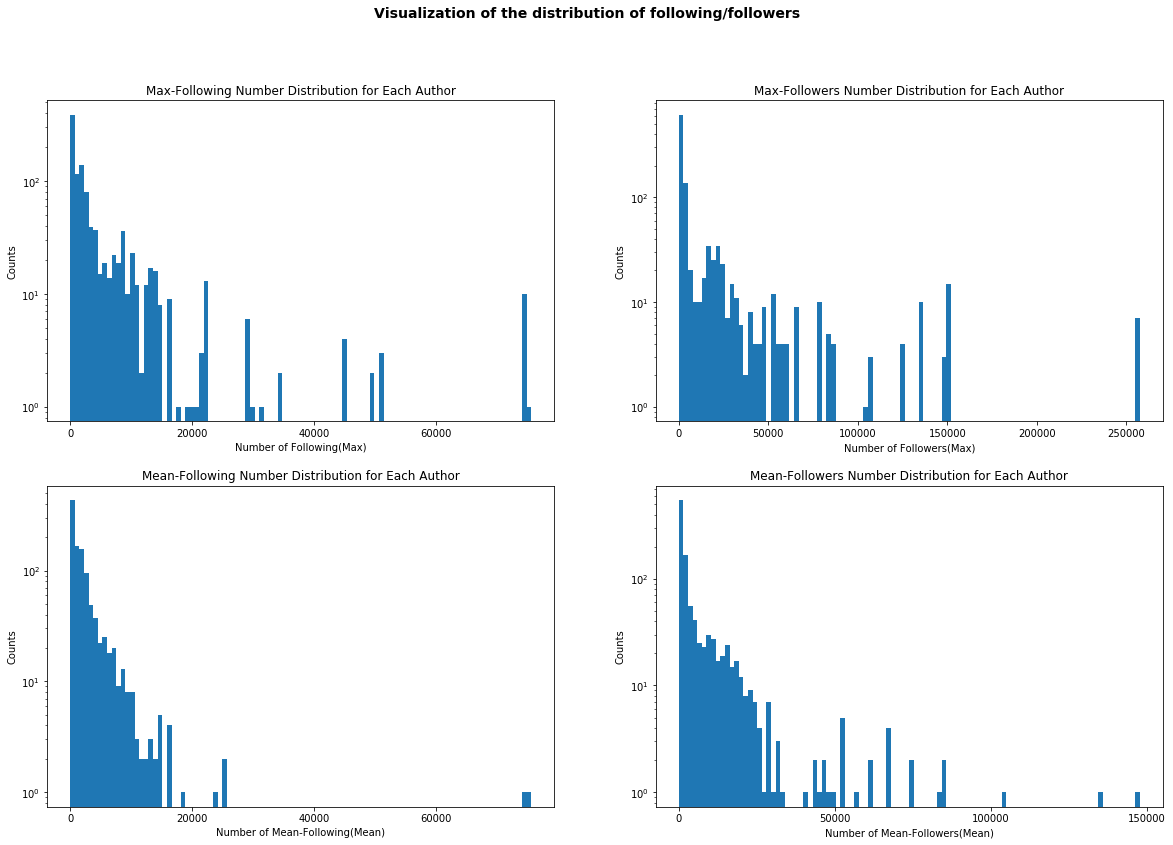

In [27]:
# Plot results
fig=plt.figure(figsize=(20,13))
fig.suptitle('Visualization of the distribution of following/followers', fontsize=14, fontweight='bold')

ax = fig.add_subplot(221)
ax.hist(following.max_following,bins=100,log=True)
ax.set_xlabel('Number of Following(Max)')
ax.set_ylabel('Counts')
ax.set_title(r'Max-Following Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax2 = fig.add_subplot(222)
ax2.hist(followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of Followers(Max)')
ax2.set_ylabel('Counts')
ax2.set_title(r'Max-Followers Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax3 = fig.add_subplot(223)
ax3.hist(avgfollowing.mean_following,bins=100,log=True)
ax3.set_xlabel('Number of Mean-Following(Mean)')
ax3.set_ylabel('Counts')
ax3.set_title(r'Mean-Following Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

ax4 = fig.add_subplot(224)
ax4.hist(avgfollowers.mean_followers,bins=100,log=True)
ax4.set_xlabel('Number of Mean-Followers(Mean)')
ax4.set_ylabel('Counts')
ax4.set_title(r'Mean-Followers Number Distribution for Each Author')
plt.locator_params(axis='x',nbins=6)

plt.show()

According to the previous plot, we have the interest to restrict our representation to the author with a smaller number of following/followers.

In [28]:
counters=italian_tweets.groupby('author').count()
less_following = following.loc[following['max_following'] < 50000]
less_followers = followers.loc[followers['max_followers'] < 50000]

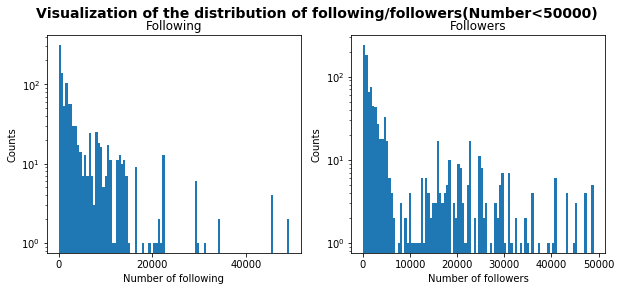

In [29]:
# Plot the results
fig=plt.figure(figsize=(10,4))
fig.suptitle('Visualization of the distribution of following/followers(Number<50000)', fontsize=14, fontweight='bold')
ax = fig.add_subplot(121)

ax.hist(less_following.max_following,bins=100, log=True)
ax.set_xlabel('Number of following')
ax.set_ylabel('Counts')
ax.set_title(r'Following')
plt.locator_params(axis='x',nbins=4)

ax2 = fig.add_subplot(122)
ax2.hist(less_followers.max_followers,bins=100,log=True)
ax2.set_xlabel('Number of followers')
ax2.set_ylabel('Counts')
ax2.set_title(r'Followers')

plt.show()

> The numbers we have found (the number of author with a certain number of following/followers is relative high) confirme us that this analysis makes sense; therefore, we continue our exploratory analyzes to look for new validations.

### Authors: activity

> In this part the idea is to investigate the distribution of the average number of tweets/day. In particular after removing duplicates after the concatenation, we calculate for each author the average number of tweets sent out per day. Finally we store the information about the most prolific authors, i.e. authors whose average/day is large enough.

In [30]:
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})

# Concatenate the two dataset using columns of interest
authors=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])

# Eliminate duplicates
authors=authors.drop_duplicates(subset='content')
authors.head()

,content,author,time
0,RT @MuseoOmero: #14marzo #paesaggioitaliano Mo...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10:00
1,RT @Radio3tweet: La ministra @valeriafedeli in...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38:00
2,RT @Radio1Rai: NEWS/ Attacco #Londra: May riun...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09:00
3,RT @PiazzapulitaLA7: Assolutamente non ci alle...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27:00
4,RT @ilmessaggeroit: Dopo Ivrea/ Le risposte ma...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18:00


Here we count the total number of all contents:

In [31]:
authors.content.count()

35051

We find out that every content is unique:

In [32]:
len(authors.content.unique())

35051

In [33]:
authors.dtypes

content            object
author             object
time       datetime64[ns]
dtype: object

In [34]:
authors['time']=authors['time'].apply(lambda x: x.date())#Only keep the date
#Count total number of tweets the author sent out in one day:
authors=authors.groupby(['author','time']).agg('count').rename(columns={'content':'tot'})
#Take the average number of tweets one author sent out per day:
authors=authors.groupby(by='author',as_index=True).agg({'tot':'mean'}).reset_index().rename(columns={'tot':'avg'})

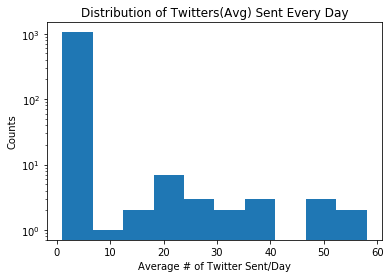

In [36]:
# Plot the results
plt.hist(authors.avg, log=True)
plt.xlabel('Average # of Twitter Sent/Day')
plt.ylabel('Counts')
plt.title(r'Distribution of Twitters(Avg) Sent Every Day')
plt.show()

In [37]:
tweets=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
tweets.describe()

,content,author,time
count,35423,35423,35423
unique,35051,1085,18620
top,.@kellycaye Kelly @itsaileenkn Daniel @Stanis4...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-29 15:17:00
freq,2,3482,12
first,NaN,NaN,2012-07-09 12:16:00
last,NaN,NaN,2018-03-31 01:07:00


In [39]:
prolific=authors.loc[authors.avg>20]
tweets_prolific=tweets.copy().merge(prolific,how='right',on='author')
tweets_prolific=tweets_prolific[tweets_prolific['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]
tweets_prolific.head()
#tweets.describe()

,content,author,time,avg
0,RT @MuseoOmero: #14marzo #paesaggioitaliano Mo...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-14 11:10:00,57.081967
1,RT @Radio3tweet: La ministra @valeriafedeli in...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-16 12:38:00,57.081967
2,RT @Radio1Rai: NEWS/ Attacco #Londra: May riun...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-22 17:09:00,57.081967
3,RT @PiazzapulitaLA7: Assolutamente non ci alle...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-03-23 21:27:00,57.081967
4,RT @ilmessaggeroit: Dopo Ivrea/ Le risposte ma...,378410ae3ae135e4f2271e4cad9190bae2d5b029c58881...,2017-04-09 22:18:00,57.081967


### Italian politicians

>Here we focus on analyzing the frequency of several important italian politicians when they were mentioned in tweets. We try to find their appearance frequency in all tweets and in tweets with prolific authors separately:

In [76]:
#First we filter the tweets and only keep contents which are sent after 2017.01.01
tweets_2017=tweets[tweets['time'].apply(lambda x:x>datetime.strptime('01-01-2017', '%d-%m-%Y'))]

In [79]:
renzi=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'renzi' in x.lower())]
print("'Renzi' mentioned in tweets_prolific:", renzi.content.count(), "times")

'Renzi' mentioned in tweets_prolific: 444 times


In [80]:
renzi=tweets_2017[tweets_2017['content'].apply(lambda x: 'renzi' in x.lower())]
print("'Renzi' mentioned in all tweets:", renzi.content.count(), "times")

'Renzi' mentioned in all tweets: 587 times


Matteo Renzi is an Italian politician who served as the Prime Minister of Italy from February 2014 until December 2016(from wikipedia). From above data, he was mentioned 481 times in tweets with prolific authors, and 643 times in all tweets.

In [81]:
salvini=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'salvini' in x.lower())]
print("'Salvini' mentioned in tweets_prolific:", salvini.content.count(), "times")

'Salvini' mentioned in tweets_prolific: 135 times


In [82]:
salvini=tweets_2017[tweets_2017['content'].apply(lambda x: 'salvini' in x.lower())]
print("'Salvini' mentioned in all tweets:", salvini.content.count(), "times")

'Salvini' mentioned in all tweets: 185 times


Matteo Salvini has also been Federal Secretary of Northern League since December 2013 and the leader of Us with Salvini since December 2014(from wikipedia). From above data, he was mentioned 145 times in tweets with prolific authors, and 196 times in all tweets.

In [83]:
grillo=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'grillo' in x.lower())]
print("'Grillo' mentioned in tweets_prolific:", grillo.content.count(), "times")

'Grillo' mentioned in tweets_prolific: 129 times


In [84]:
grillo=tweets_2017[tweets_2017['content'].apply(lambda x: 'grillo' in x.lower())]
print("'Grillo' mentioned in all tweets:", grillo.content.count(), "times")

'Grillo' mentioned in all tweets: 157 times


Beppe Grillo has been involved in politics since 2009 as the co-founder (together with Gianroberto Casaleggio) of the Italian Five Star Movement political party(from wikipedia). From above data, he was mentioned 139 times in tweets with prolific authors, and 172 times in all tweets.

In [85]:
repubblica=tweets_prolific[tweets_prolific['content'].apply(lambda x: 'repubblica' in x.lower())]
print("'Repubblica' mentioned in tweets_prolific:", repubblica.content.count(), "times")

'Repubblica' mentioned in tweets_prolific: 1826 times


In [86]:
rep=tweets_2017[tweets_2017['content'].apply(lambda x: 'repubblica' in x.lower())]
print("'Repubblica' mentioned in all tweets:", repubblica.content.count(), "times")

'Repubblica' mentioned in all tweets: 1826 times


Repubblica is a best-selling Italian daily general-interest newspaper. Born as a radical leftist newspaper, it has since moderated to a milder centre-left political stance(from wikipedia). This word is popular, and only appeared in "prolific tweets" with 2123 times.

### Geographical analysis 

> In this part the idea is to investigate the distribution of tweets' citations of Italian communes(Itatian: comune) and regions(Italian: regione) geographically. In other words, for each region/commune we calculate the number of tweets that mention that region/commune.

In [48]:
#We find an excel form called "comuni.xls", and read it:
munic = pd.read_excel('comuni.xls')
munic=munic.rename(columns={'Denominazione in italiano':'comune','Denominazione regione':'regione'})[['comune','regione']]
munic.regione=munic.regione.apply(lambda x: x.lower())
munic['count']=0

#We set commune as the index here. And one region contains several communes:  
munic=munic.set_index('comune')
munic.head()

,regione,count
comune,,
Agliè,piemonte,0
Airasca,piemonte,0
Ala di Stura,piemonte,0
Albiano d'Ivrea,piemonte,0
Alice Superiore,piemonte,0


We group all communes according to their regions, and calculate the total number of regions in each comune:

In [49]:
def wordInString(word, string_value):
    return True if re.search(r'\b' + word + r'\b', string_value) else False

In [50]:
def count_c(name):
    tweet_comune=tweets[tweets['content'].apply(lambda x: wordInString(name, x))]
    total=tweet_comune.content.count()
    munic.at[name, 'count']=total

In [51]:
def count_r(name):
    tweet_reg=tweets[tweets['content'].apply(lambda x: wordInString(name.lower(), x.lower()))]
    total=tweet_reg.content.count()
    reg.at[name, 'tot']=reg.loc[name,'tot']+total

In [52]:
list_comuni=munic.index.tolist()
for m in list_comuni:
    count_c(m)

In [53]:
reg=munic.groupby(by='regione')['count'].agg('sum').reset_index().rename(columns={'count':'tot'}).set_index('regione')

In [54]:
list_regioni=reg.index.tolist()
for m in list_regioni:
    count_r(m)

The result is like the following:

In [55]:
reg

,tot
regione,
abruzzo,91
basilicata,87
calabria,244
campania,745
emilia-romagna,356
friuli-venezia giulia,55
lazio,1046
liguria,176
lombardia,786


### Time analysis

In [56]:
#We concantenate italian tweets of 2 datasets together, and drop the duplicate:
times=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
times=times.drop_duplicates(subset='content')

In [57]:
start_date_tweet = times['time'].min()
end_date_tweet = times['time'].max()
print(start_date_tweet, end_date_tweet)

2012-07-09 12:16:00 2018-03-31 01:07:00


Here we have all tweets from 2012-07-09 to 2018-03-31.  We select 3 columns: content, author, time.

In [58]:
times.dtypes

content    object        
author     object        
time       datetime64[ns]
dtype: object

In [59]:
#We only keep the date, because we want to calculate amount of tweets per day
times['time']=times['time'].apply(lambda x: x.date())
times['time'] = pd.to_datetime(times['time'])

In [60]:
#Then we group by all tweets according to their sending date:
times=times.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
times.sort_values(by='time', ascending = True, inplace = True)
times=times.set_index('time')

In [62]:
times.head()

,tot
time,
2012-07-09,11
2012-07-10,20
2012-07-11,1
2012-07-12,11
2012-07-27,1


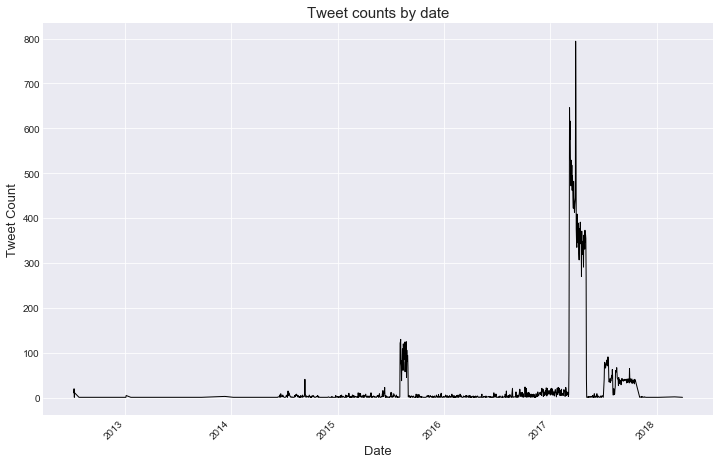

In [63]:
plt.style.use('seaborn-darkgrid')
times['tot'].plot(linestyle = "-", figsize = (12,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.show()

From the graph above, it is obvious that there is an extraordinary peak from 2017-February to 2017-March. We are going to expand more analysis based on it.

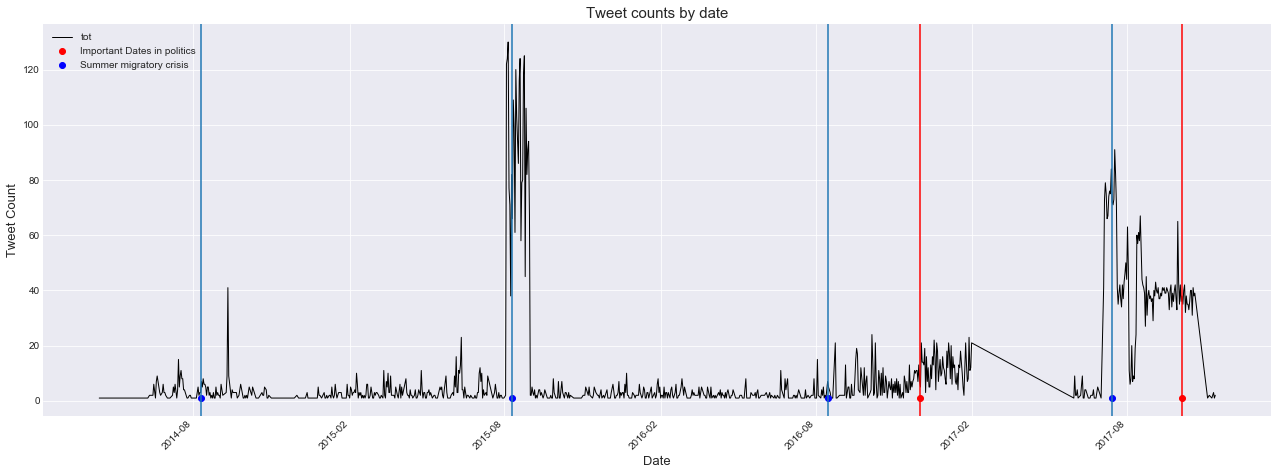

In [64]:
peak=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
peak=peak.drop_duplicates(subset='content')
peak=peak[peak['time'].apply(lambda x:
                         ((x<datetime.strptime('01-02-2017', '%d-%m-%Y') or 
                          (x>datetime.strptime('31-05-2017', '%d-%m-%Y'))) & 
                          (x>datetime.strptime('01-03-2014', '%d-%m-%Y')) & 
                          (x<datetime.strptime('15-11-2017', '%d-%m-%Y')))
                        )]
peak['time']=peak['time'].apply(lambda x: x.date())#authors.head()
peak['time'] = pd.to_datetime(peak['time'])
peak=peak.groupby(by='time',as_index=True).agg({'content':'count'}).reset_index().rename(columns={'content':'tot'})
peak.sort_values(by='time', ascending = True, inplace = True)
peak=peak.set_index('time')

dates_list = ['2016-12-01','2017-10-05']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
important_dates = pd.Series(pd.to_datetime(dates_list))

summer = ['2017-07-15','2016-08-15','2015-08-10','2014-08-10']
# 08-2017
# March-May 2017 terror attacks in Europe: London, Stockholm, Paris, St Petersburg, Manchester
# 12-2016 Italian referendum
# 08-2015 Migratory crisis in Europe
# 05-2014 European elections
summer_dates = pd.Series(pd.to_datetime(summer))

# add columns to identify important events, and mark a 0 or 1.
peak['Summer Events'] = False
peak.loc[summer_dates, 'Summer Events'] = True
peak['vals'] = 0
peak.loc[summer_dates, 'vals'] = 1

peak['Important Events'] = False
peak.loc[important_dates, 'Important Events'] = True
peak['values'] = 0
peak.loc[important_dates, 'values'] = 1

plt.style.use('seaborn-darkgrid')
peak['tot'].plot(linestyle = "-", figsize = (22,8), rot = 45, color = 'k',
                               linewidth = 1)
plt.title('Tweet counts by date', fontsize = 15)
plt.xlabel('Date', fontsize = 13)
plt.ylabel('Tweet Count', fontsize = 13)

plt.plot(peak[peak['Important Events'] == True].index.values,
         peak.loc[peak['Important Events'] == True, 'values'],
         marker = 'o', 
         color = 'r',
         linestyle = 'none',
        label = 'Important Dates in politics')

plt.plot(peak[peak['Summer Events'] == True].index.values,
         peak.loc[peak['Summer Events'] == True, 'vals'],
         marker = 'o', 
         color = 'b',
         linestyle = 'none',
        label = 'Summer migratory crisis')

for m in peak[peak['Summer Events'] == True].index.values:
    plt.axvline(x=m)
    
for m in peak[peak['Important Events'] == True].index.values:
    plt.axvline(x=m, color='r')

plt.legend(loc = 'best')

plt.show()

# 2. Data Mining

In [65]:
italian_tweets = pd.read_csv('italian_tweets.csv')
italian_tweets_old = pd.read_csv('italian_tweets_old_notusa.csv')

In [66]:
italian_tweets['tweet_time'] =  pd.to_datetime(italian_tweets['tweet_time'], format='%Y/%m/%d %H:%M')
italian_tweets_old['publish_date'] =  pd.to_datetime(italian_tweets_old['publish_date'], format='%m/%d/%Y %H:%M')
italian_tweets=italian_tweets.rename(index=str, columns={"user_display_name":"author",
                                                         "follower_count_x": "followers",
                                                         "following_count_x": "following",
                                                         "tweet_time":"time"})
italian_tweets_old=italian_tweets_old.rename(index=str, columns={"publish_date":"time"})
italian_tweets=italian_tweets.rename(index=str, columns={"tweet_text":"content"})
ita=pd.concat([italian_tweets[['content','author','time']],italian_tweets_old[['content','author','time']]])
ita=ita.drop_duplicates(subset='content')
regex = re.compile('[^a-zA-Z ]')
def returntest(text):
    text=text.lower()
    text=regex.sub('',text) 
    text=re.sub(r'(\s)http\w+', r' ', text)
    return text
new_text = ita.content.apply(returntest)
print(new_text.head(3))
new_text.to_csv("tweets_ita.csv")

0    rt museoomero marzo paesaggioitaliano mole vanvitelliana ancona un pentagono adagiato sullacqua dal  un exlazzaretto oggi sed
1    rt radiotweet la ministra valeriafedeli incontra gli studenti di amatrice negli studi di via asiago qui  raipo               
2    rt radiorai news attacco londra may riunisce comitato demergenza cobra                                                       
Name: content, dtype: object


### Association Rules

In [67]:
def draw_graph(rules, rules_to_show,strs):
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N)       
   
    for i in range (rules_to_show):      
        G1.add_nodes_from(["R"+str(i)])
    
        for a in rules.iloc[i]['antecedents']:
            G1.add_nodes_from([a])
            G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
        for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
    
    for node in G1:
        found_a_string = False
        
        for item in strs: 
            if node==item:
                found_a_string = True
        if found_a_string:
            color_map.append('yellow')
        else:
            color_map.append('red')       
 
 
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]
 
    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
    for p in pos:  # raise text positions
        pos[p][1] += 0.07
    
    nx.draw_networkx_labels(G1, pos)
    plt.show()

In [68]:
italian_tweets_text = pd.read_csv('tweets_ita.csv',header=None)
print(italian_tweets_text.shape)
stopwords = pd.read_json('stopwords-it.json')

(31851, 2)


In [69]:
stopwords = stopwords[0].tolist()

In [96]:
list_final = []
for text in italian_tweets_text[1]:
    list_final.append([word.lower() for word in text.split() 
                       if (word.lower() not in stopwords and
                           (len(word)>3 or word in ['pd','ms']))])
    
#list_final

In [71]:
te = TransactionEncoder()
te_ary = te.fit(list_final).transform(list_final)
df = pd.DataFrame(te_ary,columns=te.columns_)

In [72]:
frequent_items = apriori(df, min_support=0.001, use_colnames=True, max_len = 2)

In [73]:
couple = frequent_items [frequent_items['itemsets'].apply(lambda x: len(x)==2)]
couple = couple.sort_values(by=['support'],ascending= False)
couple.head()

,support,itemsets
1165,0.005369,"(renzi, pd)"
1103,0.004929,"(nord, corea)"
1164,0.004270,"(primarie, pd)"
1138,0.004144,"(video, lastampa)"
1098,0.002763,"(canale, ultimora)"


In [74]:
table = association_rules(frequent_items, metric="confidence", min_threshold=0.2)
table = table.sort_values(by=['confidence'],ascending= False)

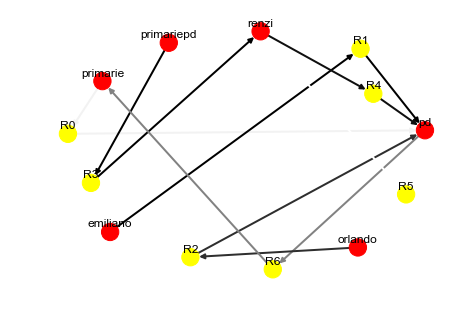

In [88]:
pd = table[(table['antecedents'].apply(lambda x: 'pd' in str(x))) | (table['consequents'].apply(lambda x: 'pd' in str(x)))]
strs=['R0', 'R1', 'R2', 'R3', 'R4', 'R5', 'R6']
draw_graph(pd, 7, strs)  

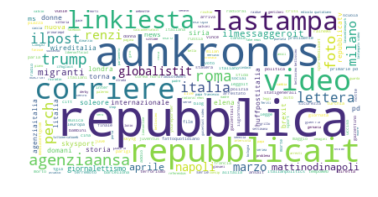

In [94]:
text = " ".join([word for tweet in list_final for word in tweet])
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

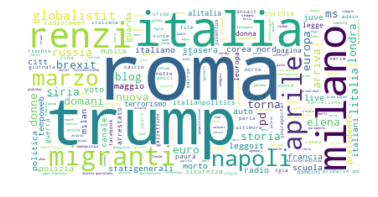

In [95]:
papers=['Corriere della Sera','repubblica','repubblicait','SoleORE','QuotidianoNazionale',
        'Gazzettait','laStampa','ilMessaggeroit','quotidianonazionale','ilpost',
        'corriere','ilgiornale','Avvenire','Tuttosport','libero',
        'FattoQuotidiano','Mattinodinapoli','huffpost','linkiesta',
        'adnkronos','agenziaansa','video','giornalettismo','ilpost',
        'lettera','huffpostitalia','agenziaitalia','skytg','skysport','internazionale',
        'perch','foto','repubblicatv','wireditalia','news','diretta','leggo','radiorai']
papers=[m.lower() for m in papers]
text = " ".join([word for tweet in list_final for word in tweet if word not in papers])
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()